In [97]:
import numpy as np
import re
import h5py as h5
import matplotlib.pyplot as plt

# Run this script for each split, side combination:
split = 'test'
side = 'l'

input_file = '/projects/nikhil/miccai/input_data_comb/data_t300_adcn.h5'

input_data = h5.File(input_file, 'r')
input_HC_all = input_data['{}_{}_data'.format(side, split)][:]
input_classes_all = input_data['{}_{}_classes'.format(side, split)][:]
input_files_all = input_data['{}_{}_files'.format(side, split)][:]
input_data.close()

id_participant = re.compile(r"""
 (?<=ADNI_)      # Match the first string after ADNI_
 (.*?)          # Lazy quantifier so it only grabs the first immediate match.
 (?=_MR)        # End at the _MR
""", re.VERBOSE)

In [98]:
# Pick the Dx group to ignore AD:0, CN:1, MCI:2 (-1 basically picks all 3 groups)
Dx_excl = -1
input_classes = input_classes_all[input_classes_all!=Dx_excl]
input_files = input_files_all[input_classes_all!=Dx_excl]
input_HC = input_HC_all[input_classes_all!=Dx_excl]

In [99]:
# Generate dictionary {subject_id:[candidate_labels]}
import collections
import scipy.stats as stats

subject_idx=[]
unique_subject_idx = []
subject_vol_dict = collections.OrderedDict()
subject_class_dict = collections.OrderedDict()

filename_sub_idx = 3 #This depends on the file names, need to find better way (regex may be?) 
#find volume indices for each unique subject
seen = set([])
for j, f in enumerate(input_files):
    subject_id = re.search(id_participant, f).group(0)
    subject_idx.append(subject_id)
    if subject_id not in subject_vol_dict:
        subject_vol_dict[subject_id]=[]
        subject_class_dict[subject_id]=[]
    subject_vol_dict[subject_id].append(j)
    subject_class_dict[subject_id].append(input_classes[j])

    if subject_id not in seen:
        unique_subject_idx.append(subject_id)
        seen.add(subject_id)
    
print "Dictionary length: " + str(len(subject_vol_dict))
fuse_vol_array = np.zeros((len(set(subject_idx)),input_HC.shape[1]))
fuse_class_array = np.zeros(len(set(subject_idx)))
j=0

for j, i in enumerate(unique_subject_idx):
    fuse_vol = stats.mode(input_HC_all[subject_vol_dict[i]])    
    fuse_vol_array[j,:] = fuse_vol[0]
    fuse_class_array[j] = stats.mode(subject_class_dict[i])[0]
    
print len(unique_subject_idx)

Dictionary length: 110
110


In [100]:
np.sum(fuse_class_array==0),np.sum(fuse_class_array==1),np.sum(fuse_class_array==2)

(27, 33, 50)

In [101]:
# Write fused data to file

input_file = '/projects/francisco/data/ADNI/ordered_fused_ad_cn_mci_{}.h5'.format(split)
input_data = h5.File(input_file, 'a')
input_data.create_dataset('{}_hc_features'.format(side), data=input_HC_all)
input_data.create_dataset('{}_hc_features_fused'.format(side), data=fuse_vol_array)

if side == 'r':
    # Only append labels once, otherwise h5 complains.
    input_data.create_dataset('labels_fused',data=fuse_class_array)
    input_data.create_dataset('labels',data=input_classes_all)


In [102]:
input_data.close()

Class Quantities:
27
33
50
Fused Samples:
(110, 11427)
(110, 10519)


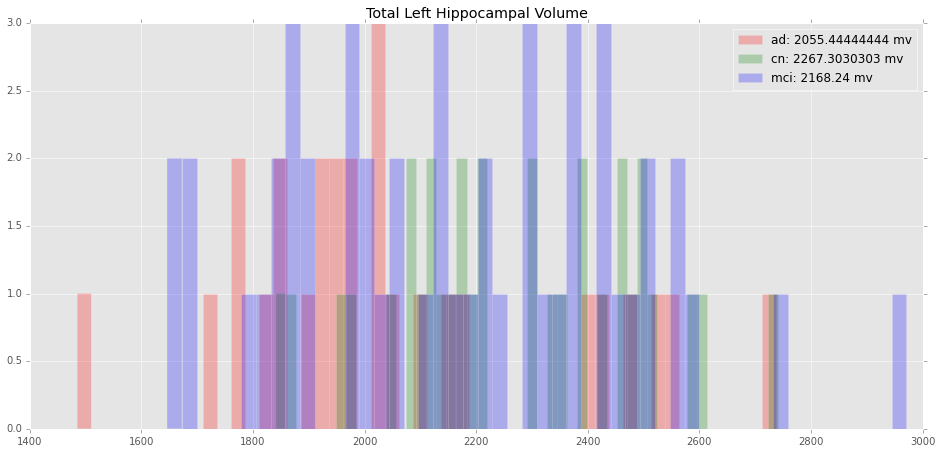

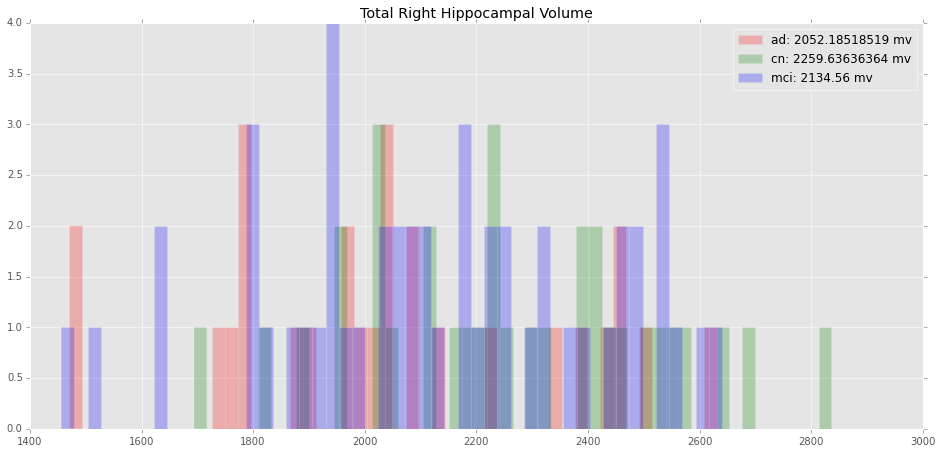

In [103]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 16, 16


# Make some plots for sanity checking:
fs = h5.File(input_file)
labels = fs['labels_fused'][:]

indad = np.where(labels==0)[0]
indcn = np.where(labels==1)[0]
indmci = np.where(labels==2)[0]

print 'Class Quantities:'
print len(indad)
print len(indcn)
print len(indmci)

l_fs = fs['l_hc_features_fused'][:]
r_fs = fs['r_hc_features_fused'][:]
print 'Fused Samples:'
print l_fs.shape
print r_fs.shape

l_fs_ad = l_fs[indad]
l_fs_cn = l_fs[indcn]
l_fs_mci = l_fs[indmci]
r_fs_ad = r_fs[indad]
r_fs_cn = r_fs[indcn]
r_fs_mci = r_fs[indmci]

l_vols_ad = np.sum(l_fs_ad, axis=1)
l_vols_cn = np.sum(l_fs_cn, axis=1)
l_vols_mci = np.sum(l_fs_mci, axis=1)

r_vols_ad = np.sum(r_fs_ad, axis=1)
r_vols_cn = np.sum(r_fs_cn, axis=1)
r_vols_mci = np.sum(r_fs_mci, axis=1)


plt.subplot(2,1,1)
plt.hist(l_vols_ad, bins=50, color='r', alpha=0.25, label='ad: {} mv'.format(np.mean(l_vols_ad)))
plt.hist(l_vols_cn, bins=50, color='g', alpha=0.25, label='cn: {} mv'.format(np.mean(l_vols_cn)))
plt.hist(l_vols_mci, bins=50, color='b', alpha=0.25, label='mci: {} mv'.format(np.mean(l_vols_mci)))
plt.legend()
plt.title('Total Left Hippocampal Volume')
plt.show()

plt.subplot(2,1,2)
plt.hist(r_vols_ad, bins=50,color='r', alpha=0.25, label='ad: {} mv'.format(np.mean(r_vols_ad)))
plt.hist(r_vols_cn, bins=50,color='g', alpha=0.25, label='cn: {} mv'.format(np.mean(r_vols_cn)))
plt.hist(r_vols_mci, bins=50,color='b', alpha=0.25, label='mci: {} mv'.format(np.mean(r_vols_mci)))
plt.legend()
plt.title('Total Right Hippocampal Volume')
plt.show()